# Paris properties price analysis

## 1) Problem description and background

Paris is one of the most expensive cities to live in the world...

## 2) Import section

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import re # library for regular expressions

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# transforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # geographic plotting library
from folium.features import DivIcon

from math import sin, cos, sqrt, atan2, radians

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist

import seaborn as sns

%matplotlib inline

print("Libraries import completed!")

Libraries import completed!


## 3) Functions section

In [3]:
def get_distance(A, B):
    """This function returns the distance in meters between two points a and b (haversine formula)
    
        Arguments:
        ----------
            A : tuple
                a pair of latitude, longitude coordinates (in degrees)
            B : tuple
                a pair of latitude, longitude coordinates (in degrees)"""
    
    R = 6373000 #aprox Earth radius in meters
    latA = radians(A[0])
    longA = radians(A[1])
    latB = radians(B[0])
    longB = radians(B[1])

    delta_long = longB - longA
    delta_lat = latB - latA

    a = sin(delta_lat / 2)**2 + cos(latA) * cos(latB) * sin(delta_long / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

print("Function get_distance created!")

Function get_distance created!


In [4]:
def color_code(s):
    '''
    highlight the maximum in a Series with green background.
    '''
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

## 4) Data retrieval

GeoJSON file with the definition of Paris neighborhoods (arrondissements)

In [5]:
# Source: Paris city hall
!wget 'https://www.data.gouv.fr/en/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c' -q -O 'paris_arrondissements.json'
file_name = 'paris_arrondissements.json'
print('Data downloaded to file %s' % file_name)
geo_paris = file_name
print('Variable geo_paris instantiated')

Data downloaded to file paris_arrondissements.json
Variable geo_paris instantiated


CSV file (';' separated) with coordinates of neighborhood central point

In [6]:
# Source: Paris open data
!wget 'https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=csv&timezone=Europe/London&lang=fr&use_labels_for_header=true&csv_separator=%3B' -q -O 'paris_arrondissements_coords.csv'
file_name = 'paris_arrondissements_coords.csv'
print('Data downloaded to file %s' % file_name)
paris_coords = pd.read_csv(file_name, sep=';')
print('Variable paris_coords instantiated')

Data downloaded to file paris_arrondissements_coords.csv
Variable paris_coords instantiated


Neighborhoods used properties price per square meter, scrapped from web page directly into a dataframe and then saved as CSV

In [7]:
# Source: Chamber of Notaries of Paris
data_url = 'https://droit-finances.commentcamarche.com/faq/7409-immobilier-a-paris-prix-au-m2-des-arrondissements'
my_request = requests.get(data_url)

if my_request:
    print("Data retrieved from %s with success!" % data_url)
else:
    print("Failed to read from %s with error code %s" % (data_url, my_request.status_code))

Data retrieved from https://droit-finances.commentcamarche.com/faq/7409-immobilier-a-paris-prix-au-m2-des-arrondissements with success!


In [8]:
# Reading price per square meter
html_code = my_request.text
neighborhood_list = []
price_list = []

find_neighborhood = re.compile(r"\<a name='(?P<number>\d+)(?P<remaining>.+)", re.DOTALL)
find_price = re.compile(r"(?P<number>[\d\s]+)€(?P<remaining>.+)", re.DOTALL)

while True:
    # Search for neighborhood
    result = find_neighborhood.search(html_code)
    if result is None:
        break
    neighborhood_list.extend([result.group('number')])
    html_code = result.group('remaining')
    # Search for price per square meter
    result = find_price.search(html_code)
    if result is None:
        break
    price = re.sub(r'\D','', result.group('number'))
    price_list.extend([int(price)])
    html_code = result.group('remaining') 
    
df_prices = pd.DataFrame({'Neighborhood': neighborhood_list, 'PricePerM2': price_list})
print('Dataframe generated!')

file_name = 'paris_prices_pm2.csv'
df_prices.to_csv(file_name, index=False)
print('Dataframe written to file %s' % file_name)

Dataframe generated!
Dataframe written to file paris_prices_pm2.csv


## 5) Data description

For this analysis i have gathered data from several data sources and tried to limit myself to credible sources, since nowadays there's a great variety of providers for the same kind of data.

Since this analysis will focus on the average price per m2 per neighborhood ("arrondissements") of used properties and the density of services on those neighborhoods (or proximity of services when they are not available "locally"), i need to gather information on:

> **(1)** Geographical information of each neighborhood that allows me to depict each neighborhood on a map (visualization purposes)

> **(2)** Geographical coordinates of a central point in each neighborhood that allows me to search for venues/services on a given radius of that point

> **(3)** Average price per m2 of used properties on each neighborhood

> **(4)** Information about venues/services along Paris's neighborhoods

Here's a summary of my choices for each data requirement as enumerated above:

> **(1)** GeoJSON file downloaded from *https://www.data.gouv.fr* with data provided by Paris city hall (2019)

> **(2)** CSV file downloaded from *https://opendata.paris.fr* with data provided by Paris city hall (2013)

> **(3)** Data (neighborhood and average price per m2) scrapped from *https://droit-finances.commentcamarche.com* with data provided by Paris Chamber of Notaries as a result of effective property sales on 2019 third quarter

> **(4)** Data retrieved with FourSquare API


## 6) Shaping the dataframe

In [9]:
# Process dataframe with geographical information
df_paris = paris_coords[['C_AR', 'L_AROFF', 'Geometry X Y']].copy(deep=True)
df_paris['Lat'] = df_paris['Geometry X Y'].apply(lambda x: float(x.split(',')[0]))
df_paris['Lon'] = df_paris['Geometry X Y'].apply(lambda x: float(x.split(',')[1]))
df_paris.drop(['Geometry X Y'], axis=1, inplace=True)
df_paris.columns = ['Neighborhood', 'Name', 'Lat', 'Lon']
df_paris.sort_values(by='Neighborhood', axis=0, inplace=True)
df_paris.reset_index(drop=True, inplace=True)
df_paris.head()

,Neighborhood,Name,Lat,Lon
0,1,Louvre,48.862563,2.336443
1,2,Bourse,48.868279,2.342803
2,3,Temple,48.862872,2.360001
3,4,Hôtel-de-Ville,48.854341,2.357630
4,5,Panthéon,48.844443,2.350715


In [10]:
# Merging price dataframe with coordinates dataframe
df_prices['Neighborhood'] = df_prices['Neighborhood'].apply(int)
df_paris = df_paris.merge(df_prices, left_on='Neighborhood', right_on='Neighborhood')
df_paris

,Neighborhood,Name,Lat,Lon,PricePerM2
0,1,Louvre,48.862563,2.336443,12840
1,2,Bourse,48.868279,2.342803,11250
2,3,Temple,48.862872,2.360001,12260
3,4,Hôtel-de-Ville,48.854341,2.357630,12790
4,5,Panthéon,48.844443,2.350715,12140
5,6,Luxembourg,48.849130,2.332898,14180
6,7,Palais-Bourbon,48.856174,2.312188,13230
7,8,Élysée,48.872721,2.312554,11240
8,9,Opéra,48.877164,2.337458,10730
9,10,Entrepôt,48.876130,2.360728,9730


## 7) Visualizing neighborhoods

In [11]:
paris_lat = 48.86
paris_lon = 2.35

paris_map = folium.Map(location=[paris_lat, paris_lon], zoom_start=12)
c_map = folium.Choropleth(geo_data=geo_paris, 
                          data=df_paris,
                          columns=['Neighborhood', 'PricePerM2'],
                          key_on='feature.properties.c_ar',
                          fill_color='YlGn',
                          fill_opacity=0.7,
                          line_opacity=0.2,
                          legend_name='Price per m2 (€)')
c_map.add_to(paris_map)

fg = folium.FeatureGroup(name='Neighborhood Info')
for idx, row in df_paris.iterrows():
    fg.add_child(folium.Marker(location=[row['Lat']+0.002, row['Lon']-0.002],
                               icon=DivIcon(icon_size=(100,36),
                                            icon_anchor=(0,0),
                                            html='<div style="font-size: 10pt;color: #000000">%s</div>' % 
                                            row['Neighborhood'],)))
    fg.add_child(folium.Marker(location=[row['Lat'], row['Lon']],
                               radius=5,
                               color='black',
                               fill=True,
                               popup=row['Name']+' ('+str(row['Neighborhood'])+') - '+str(row['PricePerM2'])+' €',
                               fill_color='blue',
                               fill_opacity=0.7))

paris_map.add_child(fg)

paris_map

We can see that centrality is one of the factors for higher price per m2, but is it just for centrality sake or is it related to the kind of services provided on central neighborhoods?

We can also see, for instance, that Passy (16eme arrondissement) and Gobelins (13eme arrondissement) are both peripheral neighborhoods, but the price per m2 in Passy is almost 18% higher than in Gobelins.

The next step will be to gather information about services around each neighborhood. For that i will use the FourSquare API, but first i need to define a radius in which the venues will be explored.

If i define a fixed radius that is too high there will be an overlap effect on central neighborhoods, but on the other way if I opt for smaller radius i will not be capturing all the characteristics of peripherical neighborhoods (which are bigger).

Let's first visualize the effect of picking a small radius and the a big one.

In [12]:
# Map with a small radius
paris_small_radius_map = folium.Map(location=[paris_lat, paris_lon], zoom_start=12)
c_map.add_to(paris_small_radius_map)

fg = folium.FeatureGroup(name='Small Radius')
for idx, row in df_paris.iterrows():
    fg.add_child(folium.Circle(location=[row['Lat'], row['Lon']],
                               radius=500,
                               popup=row['Name']+' ('+str(row['Neighborhood'])+') - '+str(row['PricePerM2'])+' €',
                               color='blue',
                               fill=True,
                               fill_color='blue',
                               fill_opacity=0.7))

paris_small_radius_map.add_child(fg)

paris_small_radius_map

As expected, a small radius (500m) almost avoids overlaping, but for peripherical neighborhoods it doesn't capture most of the neighborhoods features.

In [13]:
# Map with a big radius
paris_big_radius_map = folium.Map(location=[paris_lat, paris_lon], zoom_start=12)
c_map.add_to(paris_big_radius_map)

fg = folium.FeatureGroup(name='Big Radius')
for idx, row in df_paris.iterrows():
    fg.add_child(folium.Circle(location=[row['Lat'], row['Lon']],
                               radius=1500,
                               popup=row['Name']+' ('+str(row['Neighborhood'])+') - '+str(row['PricePerM2'])+' €',
                               color='blue',
                               fill=True,
                               fill_color='blue',
                               fill_opacity=0.7))

paris_big_radius_map.add_child(fg)

paris_big_radius_map

As expected, a big radius (1500m) captures the essence of peripherical neighborhoods but causes too much overlapping.

The approach will be to dynamically define the radius for each neighborhood.

I will assume that the coordinates i have, represent roughly the center of each neighborhood. I will then build a matrix of distances between each neighborhood central point, picking the distance to the closest neighborhood central point and dividing it by two (since it's fair to assume that the border between neighborhoods is at the middle of the distance). This will be the radius when exploring venues (proportional to the neighborhood's dimension).

In [14]:
# Build empty distance matrix between neighborhoods as a dataframe

num_points = df_paris.shape[0]
empty_matrix = np.zeros((num_points, num_points))

distance_matrix = pd.DataFrame(empty_matrix, index=df_paris['Neighborhood'], columns=df_paris['Neighborhood'])
distance_matrix.head()

Neighborhood,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Neighborhood,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Build an auxiliary dictionary to translate neighborhoods in coordenates

neighborhood_coordinates = {}
for i, row in df_paris.iterrows():
    neighborhood_coordinates[row['Neighborhood']] = (row['Lat'], row['Lon'])
    
neighborhood_coordinates

{1: (48.8625627018, 2.33644336205),
 2: (48.8682792225, 2.34280254689),
 3: (48.86287238, 2.3600009859),
 4: (48.8543414263, 2.35762962032),
 5: (48.8444431505, 2.35071460958),
 6: (48.8491303586, 2.33289799905),
 7: (48.8561744288, 2.31218769148),
 8: (48.8727208374, 2.3125540224),
 9: (48.8771635173, 2.33745754348),
 10: (48.8761300365, 2.36072848785),
 11: (48.8590592213, 2.3800583082),
 12: (48.8349743815, 2.42132490078),
 13: (48.8283880317, 2.36227244042),
 14: (48.8292445005, 2.3265420442),
 15: (48.8400853759, 2.29282582242),
 16: (48.8603921054, 2.26197078836),
 17: (48.887326522, 2.30677699057),
 18: (48.892569268, 2.34816051956),
 19: (48.8870759966, 2.38482096015),
 20: (48.8634605789, 2.40118812928)}

In [16]:
# Calculate distances

for col in distance_matrix.columns:
    for idx in distance_matrix.index:
        if col != idx:
            if distance_matrix.at[idx, col] == 0:
                distance = get_distance(neighborhood_coordinates[idx], neighborhood_coordinates[col])
                distance_matrix.at[idx, col] = distance
                distance_matrix.at[col, idx] = distance

distance_matrix.replace(0, np.nan, inplace=True)
distance_matrix.head()

Neighborhood,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Neighborhood,,,,,,,,,,,,,,,,,,,,
1,NaN,787.914721,1724.155903,1800.007230,2270.003513,1516.439585,1911.952904,2081.308619,1625.740490,2331.183487,3215.315524,6929.385759,4245.479729,3776.182863,4054.899926,5454.956163,3506.746391,3445.929753,4467.650901,4738.675274
2,787.914721,NaN,1394.734188,1892.255529,2713.775410,2249.875244,2613.716307,2267.543022,1062.754743,1575.597334,2912.629756,6837.563963,4660.332035,4501.997645,4817.962082,5979.320294,3381.367746,2730.056692,3717.419515,4305.543710
3,1724.155903,1394.734188,NaN,964.634558,2159.612978,2504.133121,3577.362872,3640.276509,2290.680331,1475.607224,1527.784995,5456.776950,3839.290313,4470.916449,5531.463822,7178.745682,4749.649925,3414.853796,3247.253371,3014.521908
4,1800.007230,1892.255529,964.634558,NaN,1211.749970,1900.653497,3331.919090,3880.494297,2936.410649,2434.127506,1723.243071,5136.126596,2906.730972,3601.626290,5001.464858,7032.789361,5225.240951,4308.137749,4149.095088,3345.096923
5,2270.003513,2713.775410,2159.612978,1211.749970,NaN,1404.483739,3107.151649,4206.148722,3766.555582,3599.899656,2693.611733,5275.433467,1976.140605,2447.418926,4265.331281,6733.007836,5752.183924,5356.320824,5358.617364,4256.785412


In [17]:
# Build a dictionary with the maximum radius from each neighborhood without overlaping another neighborhood

distance_matrix['Radius'] = distance_matrix.min(axis=1)
neighborhood_radius = {}

for idx in distance_matrix.index:
    neighborhood_radius[idx] = distance_matrix.at[idx,'Radius']/2
    
neighborhood_radius

{1: 393.9573604163142,
 2: 393.9573604163142,
 3: 482.31727897802085,
 4: 482.31727897802085,
 5: 605.8749847514338,
 6: 702.241869711919,
 7: 853.146597983403,
 8: 839.324555165213,
 9: 531.3773715833789,
 10: 737.8036117966111,
 11: 763.8924972667907,
 12: 1747.2722504378742,
 13: 988.0703027068997,
 14: 1130.1569452691554,
 15: 1141.3885888535324,
 16: 1597.025907568369,
 17: 839.324555165213,
 18: 941.9640453567895,
 19: 1070.9799051811024,
 20: 810.9282429440774}

In [18]:
# Map with a dynamic radius for each neighborhood (minimum distance before overlaping another neighborhood)

paris_dynamic_radius_map = folium.Map(location=[paris_lat, paris_lon], zoom_start=12)
c_map.add_to(paris_dynamic_radius_map)

fg = folium.FeatureGroup(name='Dynamic Radius')
for idx, row in df_paris.iterrows():
    fg.add_child(folium.Circle(location=[row['Lat'], row['Lon']],
                               radius=neighborhood_radius[row['Neighborhood']],
                               popup=row['Name']+' ('+str(row['Neighborhood'])+') - '+str(row['PricePerM2'])+' €',
                               color='blue',
                               fill=True,
                               fill_color='blue',
                               fill_opacity=0.7))

paris_dynamic_radius_map.add_child(fg)

paris_dynamic_radius_map

With a dynamic radius it seems we get a more fair definition of neighborhood.

At first sight we can see that Louvre (1er arrondissement) and Reuilly (12eme arrondissement) are the only neighborhoods for which the radius doesn't cover the majority of the neighborhood. Even though it seems more balanced than the previous approaches (500m and 1500m).

In [19]:
# Integrate radius in the main dataframe
df_paris['Radius'] = list(neighborhood_radius.values())

df_paris.head()

,Neighborhood,Name,Lat,Lon,PricePerM2,Radius
0,1,Louvre,48.862563,2.336443,12840,393.957360
1,2,Bourse,48.868279,2.342803,11250,393.957360
2,3,Temple,48.862872,2.360001,12260,482.317279
3,4,Hôtel-de-Ville,48.854341,2.357630,12790,482.317279
4,5,Panthéon,48.844443,2.350715,12140,605.874985


## 8) Retrieving venue information

I will now retireve venues/services information from the FourSquare API. I will start by imposing a limit of 100 venues per neighborhood and then analyze the data and adjust as needed.

Also, i will use grouped categories, since it shouldn't mather to know what kind of restaurants are there in a neighborhood but the quantity of restaurants in general.

In [20]:
# @hidden_cell
CLIENT_ID = 'QOQNP5QLBCEEANEZIMHWICVBJ3JWGWSSTZHSWLW1BOYDIYUU' # my Foursquare ID
CLIENT_SECRET = 'G5KKOAD0ETLQMBN4P1EWID4EA1R3KWSMTEB552TV1W00PE4H' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [21]:
# Build the main component of url
credentials = 'client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
base_url = 'https://api.foursquare.com/v2/venues/'
endpoint = 'explore?'

In [22]:
# Bulid a dictionary of major categories as defined in https://developer.foursquare.com/docs/resources/categories

fs_categories = {}
fs_categories['Arts & Entertainment'] = '4d4b7104d754a06370d81259'
fs_categories['College & Univerity'] = '4d4b7105d754a06372d81259'
fs_categories['Food'] = '4d4b7105d754a06374d81259'
fs_categories['Nightlife Spot'] = '4d4b7105d754a06376d81259'
fs_categories['Outdoors & Recreation'] = '4d4b7105d754a06377d81259'
fs_categories['School'] = '4bf58dd8d48988d13b941735'
fs_categories['Police Station'] = '4bf58dd8d48988d12e941735'
fs_categories['Fire Station'] = '4bf58dd8d48988d12c941735'
fs_categories['Post Office'] = '4bf58dd8d48988d172941735'
fs_categories['Parking'] = '4c38df4de52ce0d596b336e1'
fs_categories['Medical Center'] = '4bf58dd8d48988d104941735'
fs_categories['Shop & Service'] = '4d4b7105d754a06378d81259'
fs_categories['Travel & Transport'] = '4d4b7105d754a06379d81259'
fs_categories['Spiritual Center'] = '4bf58dd8d48988d131941735'

In [23]:
venues_list=[]
for idx, row in df_paris.iterrows():
            
    # create the API request URL
    api_params = 'll='+str(row['Lat'])+','+str(row['Lon'])
    api_params += '&radius='+str(int(neighborhood_radius[row['Neighborhood']]))+'&limit=100'
    
    for cat in fs_categories.keys():
        category = '&categoryId='+fs_categories[cat]
        url = base_url+endpoint+credentials+'&'+api_params+category
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(row['Neighborhood'],
                             row['Name'],
                             v['venue']['name'],
                             v['venue']['location']['lat'],
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name'],
                             cat) for v in results])

nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood',
                         'Name',
                         'Venue',
                         'VenueLatitude',
                         'VenueLongitude',
                         'VenueCategory',
                         'VenueMajorCategory']

Now i will work to convert the category *Travel & Transport* in only *Transport* since the *Travel* component (hotels, bed & breakfast, etc.) shouldn't be a factor with direct impact on property prices.

In [24]:
nearby_venues[nearby_venues['VenueMajorCategory'] == 'Travel & Transport']['VenueCategory'].unique()

array(['Hotel', 'Metro Station', 'Bus Stop', 'Bike Rental / Bike Share',
       'Rental Car Location', 'Resort', 'Duty-free Shop', 'Boat or Ferry',
       'Tourist Information Center', 'Hostel', 'Bus Station', 'Motel',
       'Moving Target', 'Baggage Locker', 'Bed & Breakfast',
       'Train Station', 'Platform', 'Tram Station', 'Boarding House',
       'Vacation Rental', 'Intersection', 'Pier'], dtype=object)

In [25]:
to_remove = ['Hotel', 'Bike Rental / Bike Share', 'Rental Car Location', 'Resort', 'Duty-free Shop', 
             'Tourist Information Center', 'Hostel', 'Motel', 'Moving Target', 'Baggage Locker', 
             'Bed & Breakfast', 'Platform', 'Boarding House', 'Intersection']
nearby_venues = nearby_venues[~nearby_venues['VenueCategory'].isin(to_remove)]

nearby_venues[nearby_venues['VenueMajorCategory'] == 'Travel & Transport']['VenueCategory'].unique()

array(['Metro Station', 'Bus Stop', 'Boat or Ferry', 'Bus Station',
       'Train Station', 'Tram Station', 'Vacation Rental', 'Pier'],
      dtype=object)

In [26]:
nearby_venues['VenueMajorCategory'] = nearby_venues['VenueMajorCategory'].replace('Travel & Transport', 'Transport')

nearby_venues

,Neighborhood,Name,Venue,VenueLatitude,VenueLongitude,VenueCategory,VenueMajorCategory
0,1,Louvre,Musée du Louvre,48.860847,2.336440,Art Museum,Arts & Entertainment
1,1,Louvre,Comédie-Française,48.863088,2.336612,Theater,Arts & Entertainment
2,1,Louvre,Les Arts Décoratifs,48.863077,2.333393,Art Museum,Arts & Entertainment
3,1,Louvre,La Vénus de Milo (Vénus de Milo),48.859943,2.337234,Exhibit,Arts & Entertainment
4,1,Louvre,모나리자 / 라 조콘다 (Mona Lisa | La Joconde),48.860139,2.335337,Exhibit,Arts & Entertainment
5,1,Louvre,Musée de la Mode et du Textile,48.863032,2.333508,Museum,Arts & Entertainment
6,1,Louvre,"Pavillon des Sessions – Arts d'Afrique, d'Asie...",48.860724,2.332121,Art Museum,Arts & Entertainment
7,1,Louvre,Collection des Arts de l'Islam,48.860077,2.335851,Exhibit,Arts & Entertainment
8,1,Louvre,Statue Équestre de Jeanne d'Arc,48.863875,2.332186,Outdoor Sculpture,Arts & Entertainment
9,1,Louvre,Le Laboratoire,48.863181,2.340039,Art Gallery,Arts & Entertainment


Now i will integrate a counter for each category in the main dataframe, so we can see how many venues of each category are there in each neighborhood.

In [27]:
# Build a dataframe with the count per neighborhood and category
nearby_venues_groupby = nearby_venues.groupby(by=['VenueMajorCategory', 'Neighborhood']).count()
nearby_venues_groupby.drop(columns=['Venue', 'VenueLatitude', 'VenueLongitude', 'VenueCategory'], inplace=True)
nearby_venues_groupby.columns = ['Count']

nearby_venues_groupby.head()

Count
VenueMajorCategory   Neighborhood       
Arts & Entertainment 1                21
                     2                17
                     3                32
                     4                18
                     5                19

In [28]:
nearby_venues_groupby.sort_values('Count', ascending=False)

Count
VenueMajorCategory  Neighborhood       
Shop & Service      6               100
                    8               100
Food                4               100
                    5               100
                    6               100
                    7               100
                    8               100
                    9               100
                    10              100
                    11              100
                    13              100
                    14              100
                    15              100
                    17              100
                    18              100
                    2               100
Shop & Service      15               99
                    13               98
Food                12               94
                    3                92
Shop & Service      3                90
Food                16               89
Shop & Service      14               83
                    10               82
Nightlife Spot      11               82
Shop & Service      12               78
                    19               76
                    1                73
                    20               73
                    4                72
...                                 ...
Police Station      19                3
College & Univerity 20                3
Police Station      11                3
                    7                 3
Spiritual Center    20                3
                    19                3
Police Station      5                 3
Post Office         5                 3
School              1                 3
Post Office         6                 3
                    9                 3
                    17                3
                    7                 3
Police Station      6                 2
                    9                 2
Fire Station        9                 2
Spiritual Center    1                 2
Fire Station        13                1
                    19                1
                    18                1
                    16                1
                    15                1
                    10                1
                    11                1
                    8                 1
                    1                 1
                    4                 1
                    7                 1
                    6                 1
Police Station      17                1

[269 rows x 1 columns]

In [29]:
# Add counters to main dataframe

# First, i need to rectify the Travel & Transport category name on the fs_categories dictionary (on a copy of it)
new_categories = fs_categories.copy()
new_categories['Transport'] = new_categories.pop('Travel & Transport')

for cat in new_categories.keys():
    new_col = 20*[0]
    for idx, row in nearby_venues_groupby.loc[cat,].iterrows():
        new_col[idx-1] = row['Count']
    df_paris[cat] = new_col

df_paris.head()

,Neighborhood,Name,Lat,Lon,PricePerM2,Radius,Arts & Entertainment,College & Univerity,Food,Nightlife Spot,Outdoors & Recreation,School,Police Station,Fire Station,Post Office,Parking,Medical Center,Shop & Service,Spiritual Center,Transport
0,1,Louvre,48.862563,2.336443,12840,393.957360,21,5,48,16,19,3,0,1,4,6,9,73,2,10
1,2,Bourse,48.868279,2.342803,11250,393.957360,17,18,100,62,17,8,5,0,4,4,11,67,5,5
2,3,Temple,48.862872,2.360001,12260,482.317279,32,4,92,36,11,9,0,0,4,4,6,90,6,6
3,4,Hôtel-de-Ville,48.854341,2.357630,12790,482.317279,18,11,100,45,37,9,0,1,3,4,8,72,5,8
4,5,Panthéon,48.844443,2.350715,12140,605.874985,19,66,100,59,26,9,3,0,3,4,11,58,10,11


## 9) Visualizing venue information

I will now visualize the venue distribution per neighborhood.

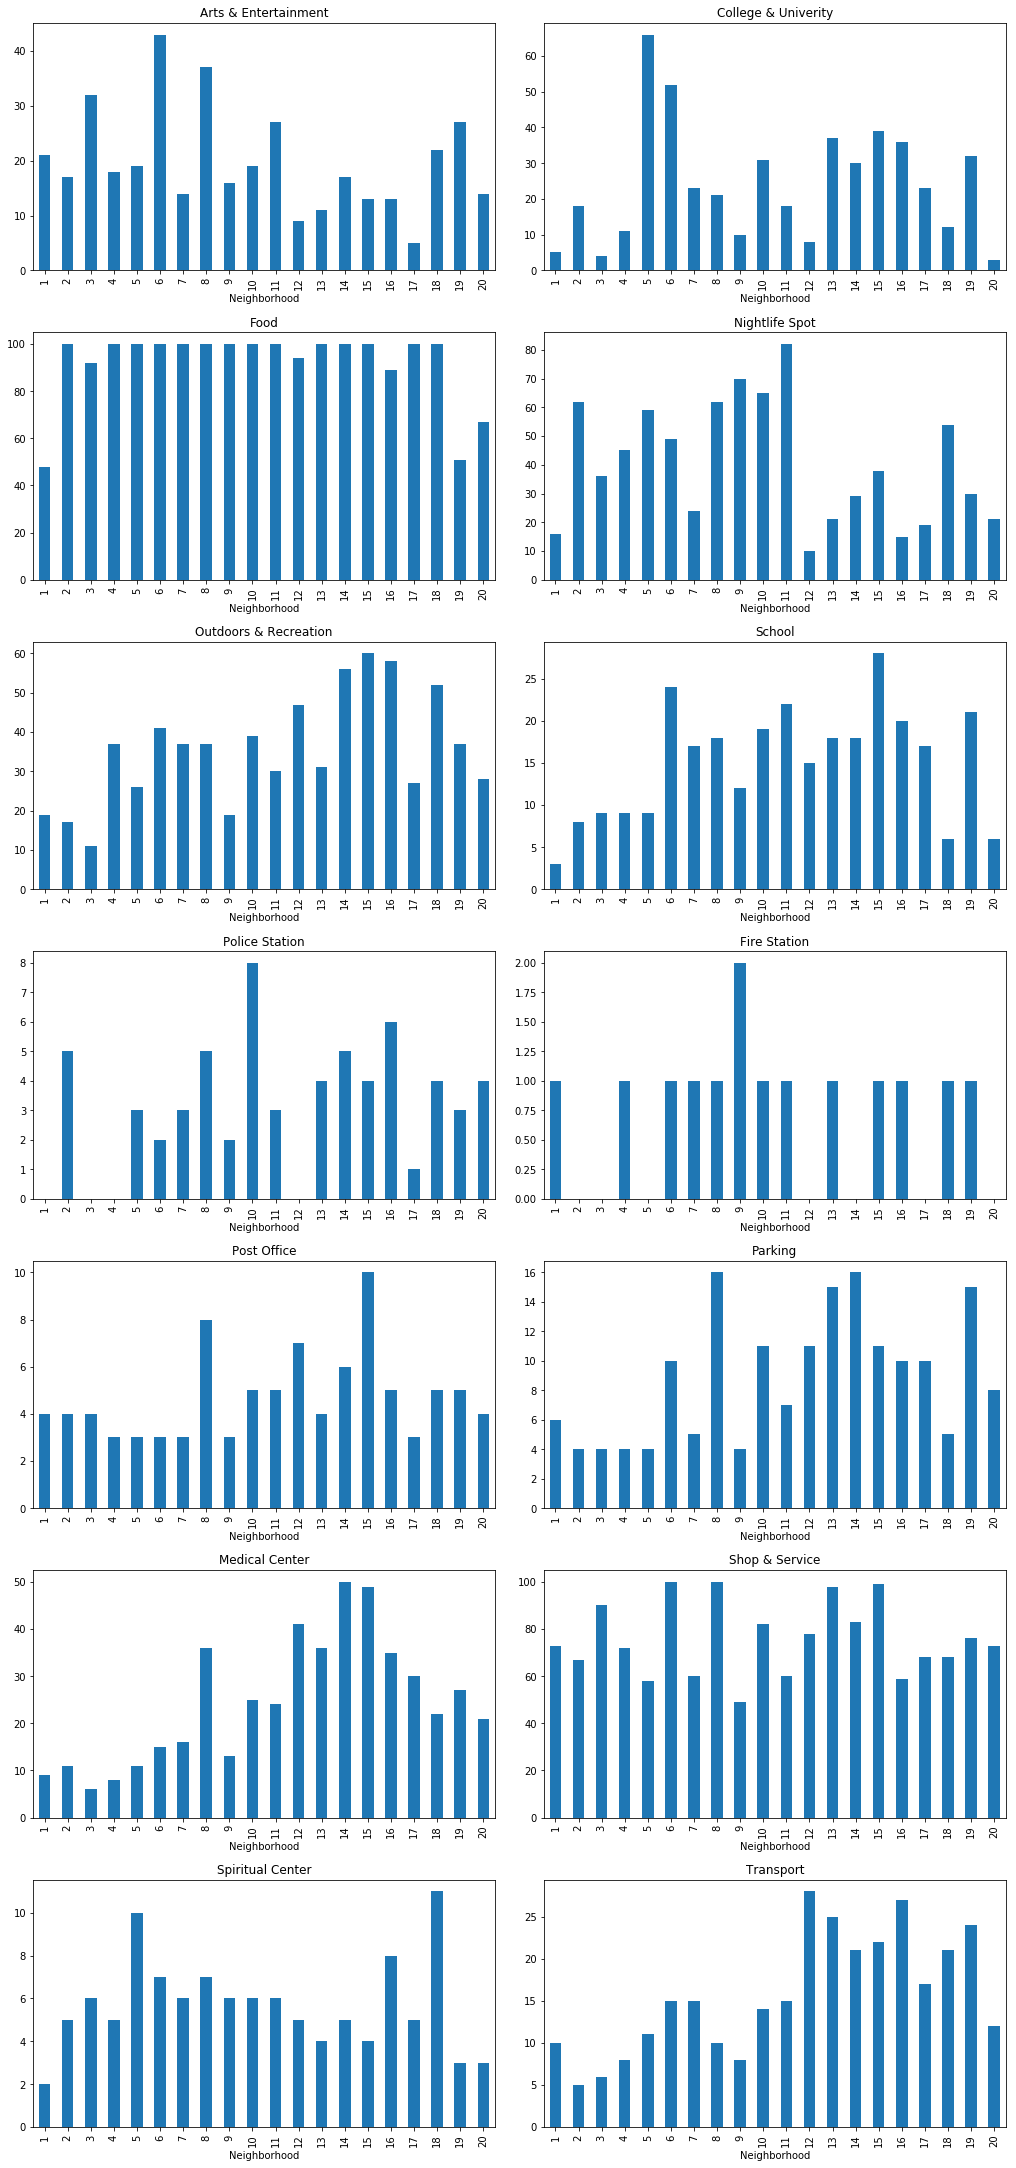

In [30]:
# Grid of plots for each category
plot_cnt = 0
rows = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
#rows = list(np.arange(0,7))*2
cols = [0, 1]*7

fig, axs = plt.subplots(7, 2, constrained_layout=True)

for cat in new_categories.keys():
    df_paris[['Neighborhood', cat]].set_index('Neighborhood').plot(ax=axs[rows[plot_cnt], cols[plot_cnt]],
                                                                   figsize=(14,30),
                                                                   kind='bar', legend=None, title=cat)
    plot_cnt += 1
    

In the above graphs we can compare the number of each category of venues between neighborhoods, but it's normal that smaller neighborhoods have fewer venues than bigger ones.

A better metric would be to depict the number of venues per m2 for the scanned area. Since all i need is a similar ratio i will divide each counter by the radius used on each neighborhood, after that i will convert all the ratios so that there's only values between 0 and 100 (it will become an index for each particular category).

In [31]:
norm_cats = ['Index_'+x.replace(' ', '') for x in list(new_categories)]
pd.set_option('display.max_columns', None)

for ratio, cat in zip(norm_cats, new_categories):
    df_paris[ratio] = df_paris[cat]/df_paris['Radius']
    df_paris[ratio] = round(100*df_paris[ratio]/df_paris[ratio].max())
    df_paris[ratio] = df_paris[ratio].apply(int)
    
df_paris

,Neighborhood,Name,Lat,Lon,PricePerM2,Radius,Arts & Entertainment,College & Univerity,Food,Nightlife Spot,Outdoors & Recreation,School,Police Station,Fire Station,Post Office,Parking,Medical Center,Shop & Service,Spiritual Center,Transport,Index_Arts&Entertainment,Index_College&Univerity,Index_Food,Index_NightlifeSpot,Index_Outdoors&Recreation,Index_School,Index_PoliceStation,Index_FireStation,Index_PostOffice,Index_Parking,Index_MedicalCenter,Index_Shop&Service,Index_SpiritualCenter,Index_Transport
0,1,Louvre,48.862563,2.336443,12840,393.957360,21,5,48,16,19,3,0,1,4,6,9,73,2,10,80,12,48,26,63,22,0,67,100,80,52,99,31,100
1,2,Bourse,48.868279,2.342803,11250,393.957360,17,18,100,62,17,8,5,0,4,4,11,67,5,5,65,42,100,100,56,59,100,0,100,53,63,91,77,50
2,3,Temple,48.862872,2.360001,12260,482.317279,32,4,92,36,11,9,0,0,4,4,6,90,6,6,100,8,75,47,30,55,0,0,82,44,28,100,75,49
3,4,Hôtel-de-Ville,48.854341,2.357630,12790,482.317279,18,11,100,45,37,9,0,1,3,4,8,72,5,8,56,21,82,59,100,55,0,55,61,44,37,80,63,65
4,5,Panthéon,48.844443,2.350715,12140,605.874985,19,66,100,59,26,9,3,0,3,4,11,58,10,11,47,100,65,62,56,43,39,0,49,35,41,51,100,72
5,6,Luxembourg,48.849130,2.332898,14180,702.241870,43,52,100,49,41,24,2,1,3,10,15,100,7,15,92,68,56,44,76,100,22,38,42,75,48,76,60,84
6,7,Palais-Bourbon,48.856174,2.312188,13230,853.146598,14,23,100,24,37,17,3,1,3,5,16,60,6,15,25,25,46,18,57,58,28,31,35,31,42,38,43,69
7,8,Élysée,48.872721,2.312554,11240,839.324555,37,21,100,62,37,18,5,1,8,16,36,100,7,10,66,23,47,47,57,63,47,32,94,100,97,64,51,47
8,9,Opéra,48.877164,2.337458,10730,531.377372,16,10,100,70,19,12,2,2,3,4,13,49,6,8,45,17,74,84,47,66,30,100,56,39,55,49,68,59
9,10,Entrepôt,48.876130,2.360728,9730,737.803612,19,31,100,65,39,19,8,1,5,11,25,82,6,14,39,39,53,56,69,75,85,36,67,78,77,60,49,75


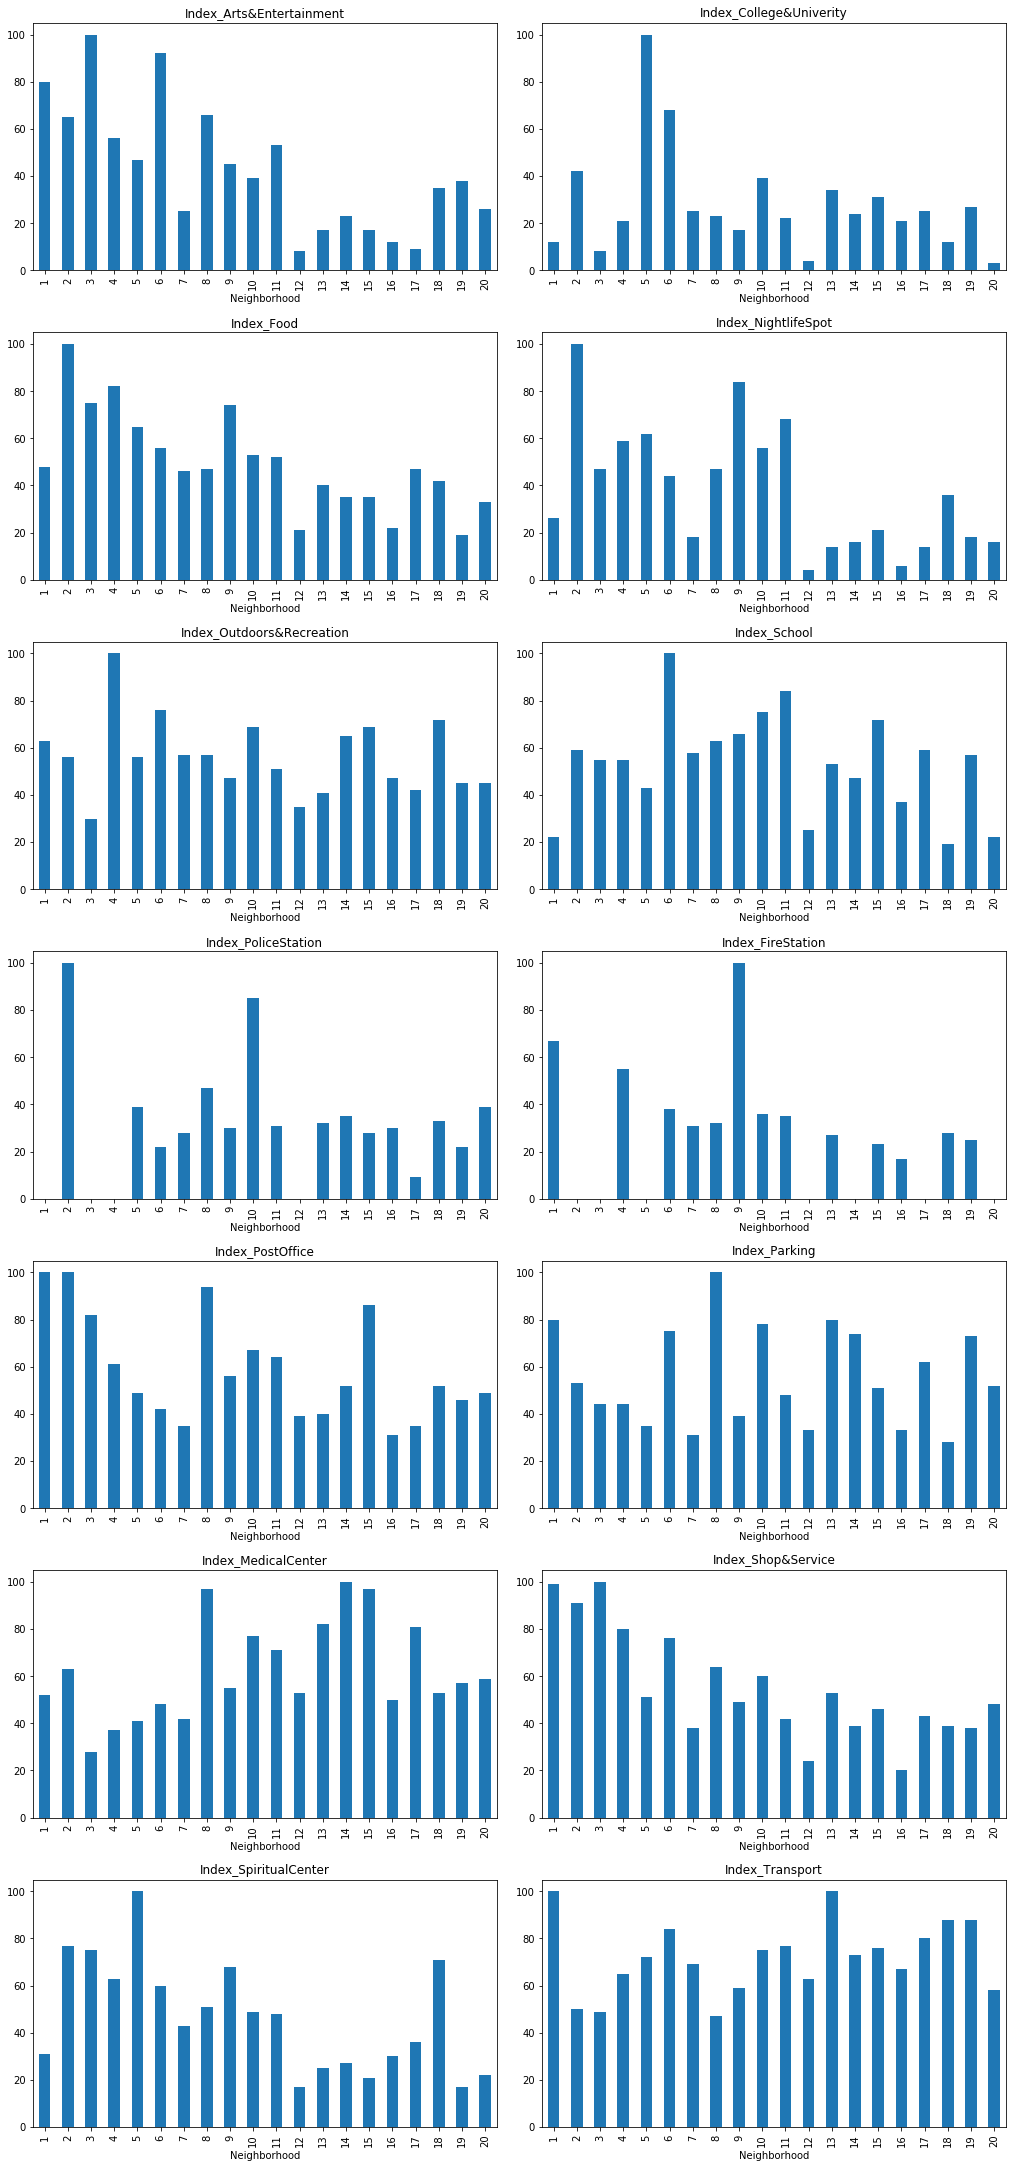

In [32]:
# Grid of plots for each category after ratio calculations
plot_cnt = 0
rows = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
#rows = list(np.arange(0,7))*2
cols = [0, 1]*7

fig, axs = plt.subplots(7, 2, constrained_layout=True)

for cat in norm_cats:
    df_paris[['Neighborhood', cat]].set_index('Neighborhood').plot(ax=axs[rows[plot_cnt], cols[plot_cnt]],
                                                                   figsize=(14,30),
                                                                   kind='bar', legend=None, title=cat)
    plot_cnt += 1

Lets compare two plots for *Nightlife Spots*, one with the absolute values and the other with index values, to see how misleading can be the use of absolute values.

Text(0.5, 0, '')

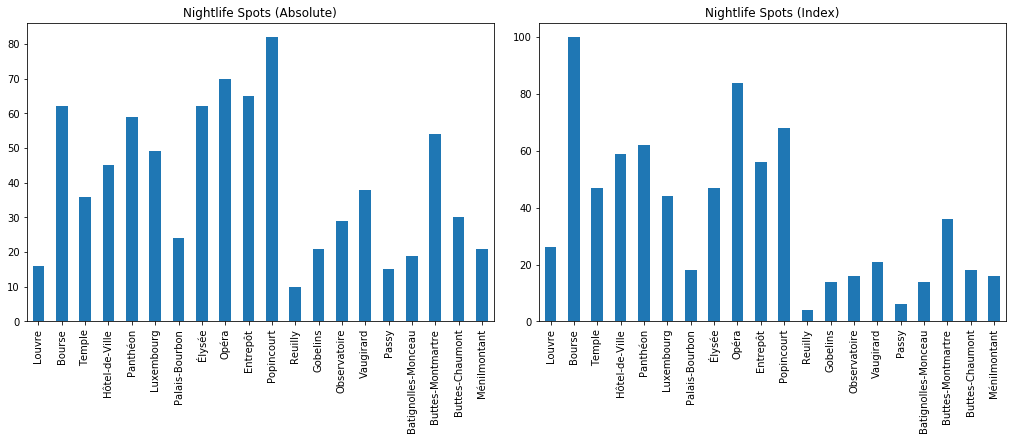

In [33]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

df_paris[['Name', 'Nightlife Spot']].set_index('Name').plot(ax=axs[0], figsize=(14,10), kind='bar', 
                                                            legend=None, 
                                                            title='Nightlife Spots (Absolute)')
axs[0].set_xlabel('')

df_paris[['Name', 'Index_NightlifeSpot']].set_index('Name').plot(ax=axs[1], figsize=(14,6), kind='bar', 
                                                                 legend=None, 
                                                                 title='Nightlife Spots (Index)')
axs[1].set_xlabel('')


## 10) Clustering neighborhoods

I will now apply some clustering to the neighborhoods, just based on the indexes previously calculated.

First i will find the optimum number of clusters using the Elbow method.

Text(0.5, 1.0, 'The Elbow Method using Inertia')

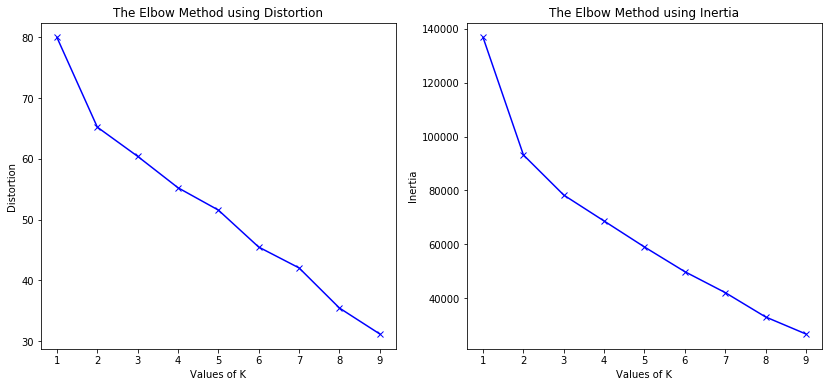

In [34]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

df_paris_clusters = df_paris[norm_cats]
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df_paris_clusters) 
    kmeanModel.fit(df_paris_clusters)     
      
    distortions.append(sum(np.min(cdist(df_paris_clusters, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_paris_clusters.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_paris_clusters, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df_paris_clusters.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

ax1.plot(K, distortions, 'bx-') 
ax1.set_xlabel('Values of K') 
ax1.set_ylabel('Distortion') 
ax1.set_title('The Elbow Method using Distortion') 

ax2.plot(K, inertias, 'bx-') 
ax2.set_xlabel('Values of K') 
ax2.set_ylabel('Inertia') 
ax2.set_title('The Elbow Method using Inertia') 

As we can see above the optimum number of clusters is two, so that's the number of cluster i will generate with K-Means.

In [35]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_paris_clusters)

# check cluster labels generated for each row in the dataframe
df_paris['Cluster'] = kmeans.labels_

df_paris.head()

,Neighborhood,Name,Lat,Lon,PricePerM2,Radius,Arts & Entertainment,College & Univerity,Food,Nightlife Spot,Outdoors & Recreation,School,Police Station,Fire Station,Post Office,Parking,Medical Center,Shop & Service,Spiritual Center,Transport,Index_Arts&Entertainment,Index_College&Univerity,Index_Food,Index_NightlifeSpot,Index_Outdoors&Recreation,Index_School,Index_PoliceStation,Index_FireStation,Index_PostOffice,Index_Parking,Index_MedicalCenter,Index_Shop&Service,Index_SpiritualCenter,Index_Transport,Cluster
0,1,Louvre,48.862563,2.336443,12840,393.957360,21,5,48,16,19,3,0,1,4,6,9,73,2,10,80,12,48,26,63,22,0,67,100,80,52,99,31,100,1
1,2,Bourse,48.868279,2.342803,11250,393.957360,17,18,100,62,17,8,5,0,4,4,11,67,5,5,65,42,100,100,56,59,100,0,100,53,63,91,77,50,1
2,3,Temple,48.862872,2.360001,12260,482.317279,32,4,92,36,11,9,0,0,4,4,6,90,6,6,100,8,75,47,30,55,0,0,82,44,28,100,75,49,1
3,4,Hôtel-de-Ville,48.854341,2.357630,12790,482.317279,18,11,100,45,37,9,0,1,3,4,8,72,5,8,56,21,82,59,100,55,0,55,61,44,37,80,63,65,1
4,5,Panthéon,48.844443,2.350715,12140,605.874985,19,66,100,59,26,9,3,0,3,4,11,58,10,11,47,100,65,62,56,43,39,0,49,35,41,51,100,72,1


Now let's try to capture the idea behind these clusters by visualizing them on the kind of plots we used before.

In [36]:
paris_map = folium.Map(location=[paris_lat, paris_lon], zoom_start=12)
c_map.add_to(paris_map)

colors = ['red','blue']

fg = folium.FeatureGroup(name='Cluster Info')
for idx, row in df_paris.iterrows():
    fg.add_child(folium.CircleMarker(location=[row['Lat'], row['Lon']],
                               radius=5,
                               color='black',
                               fill=True,
                               popup=row['Name']+' ('+str(row['Neighborhood'])+') - '+str(row['PricePerM2'])+' €',
                               fill_color=colors[row['Cluster']],
                               fill_opacity=0.7))

paris_map.add_child(fg)

paris_map

As we can see the algorithm created two clusters separating the outer neighborhoods and the inner neighborhoods and the only inner neighborhood that was placed on the outer neighborhoods cluster was *Palais-Bourbon (7eme arrondissement)*.

This is rather interesting since there was no feature that implied the geographical location of each neighborhood. Also there weren't no absolute numbers, since all there was, was index ratios of the venues categories.

If we consider the price per m2 of each neighborhood, the clustering algorithm almost separated the most expensive neighborhoods from the least expensive neighborhoods, without having any information about the price per m2. Let's visualize it.

Text(0.5, 0, 'Price per m2 (€)')

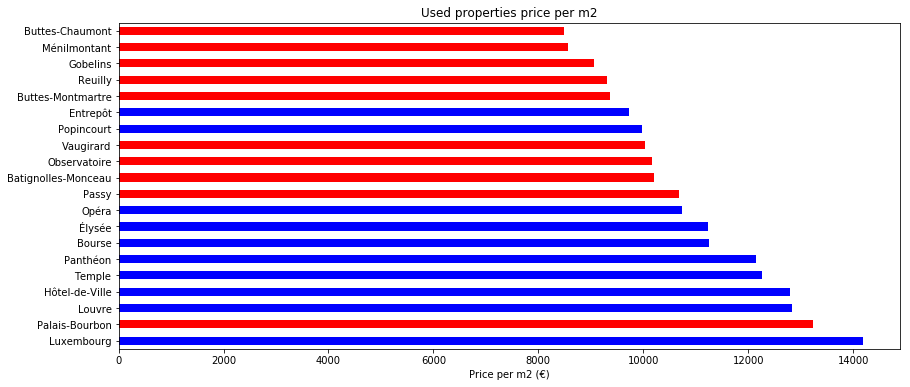

In [37]:
df_aux = df_paris.sort_values('PricePerM2', ascending=False)
colors = ['red', 'blue']
color_list = [colors[x] for x in df_aux['Cluster']]

fig, ax = plt.subplots()
df_aux[['Name', 'PricePerM2']].set_index('Name').plot(ax=ax, figsize=(14,6), 
                                                      color=[color_list], kind='barh',
                                                      legend=None, 
                                                      title='Used properties price per m2')
ax.set_ylabel('')
ax.set_xlabel('Price per m2 (€)')

I will now plot the indexes per neighborhood, per category, displaying also the cluster information in the same colors as the above map, to see what insights can we take out of it.

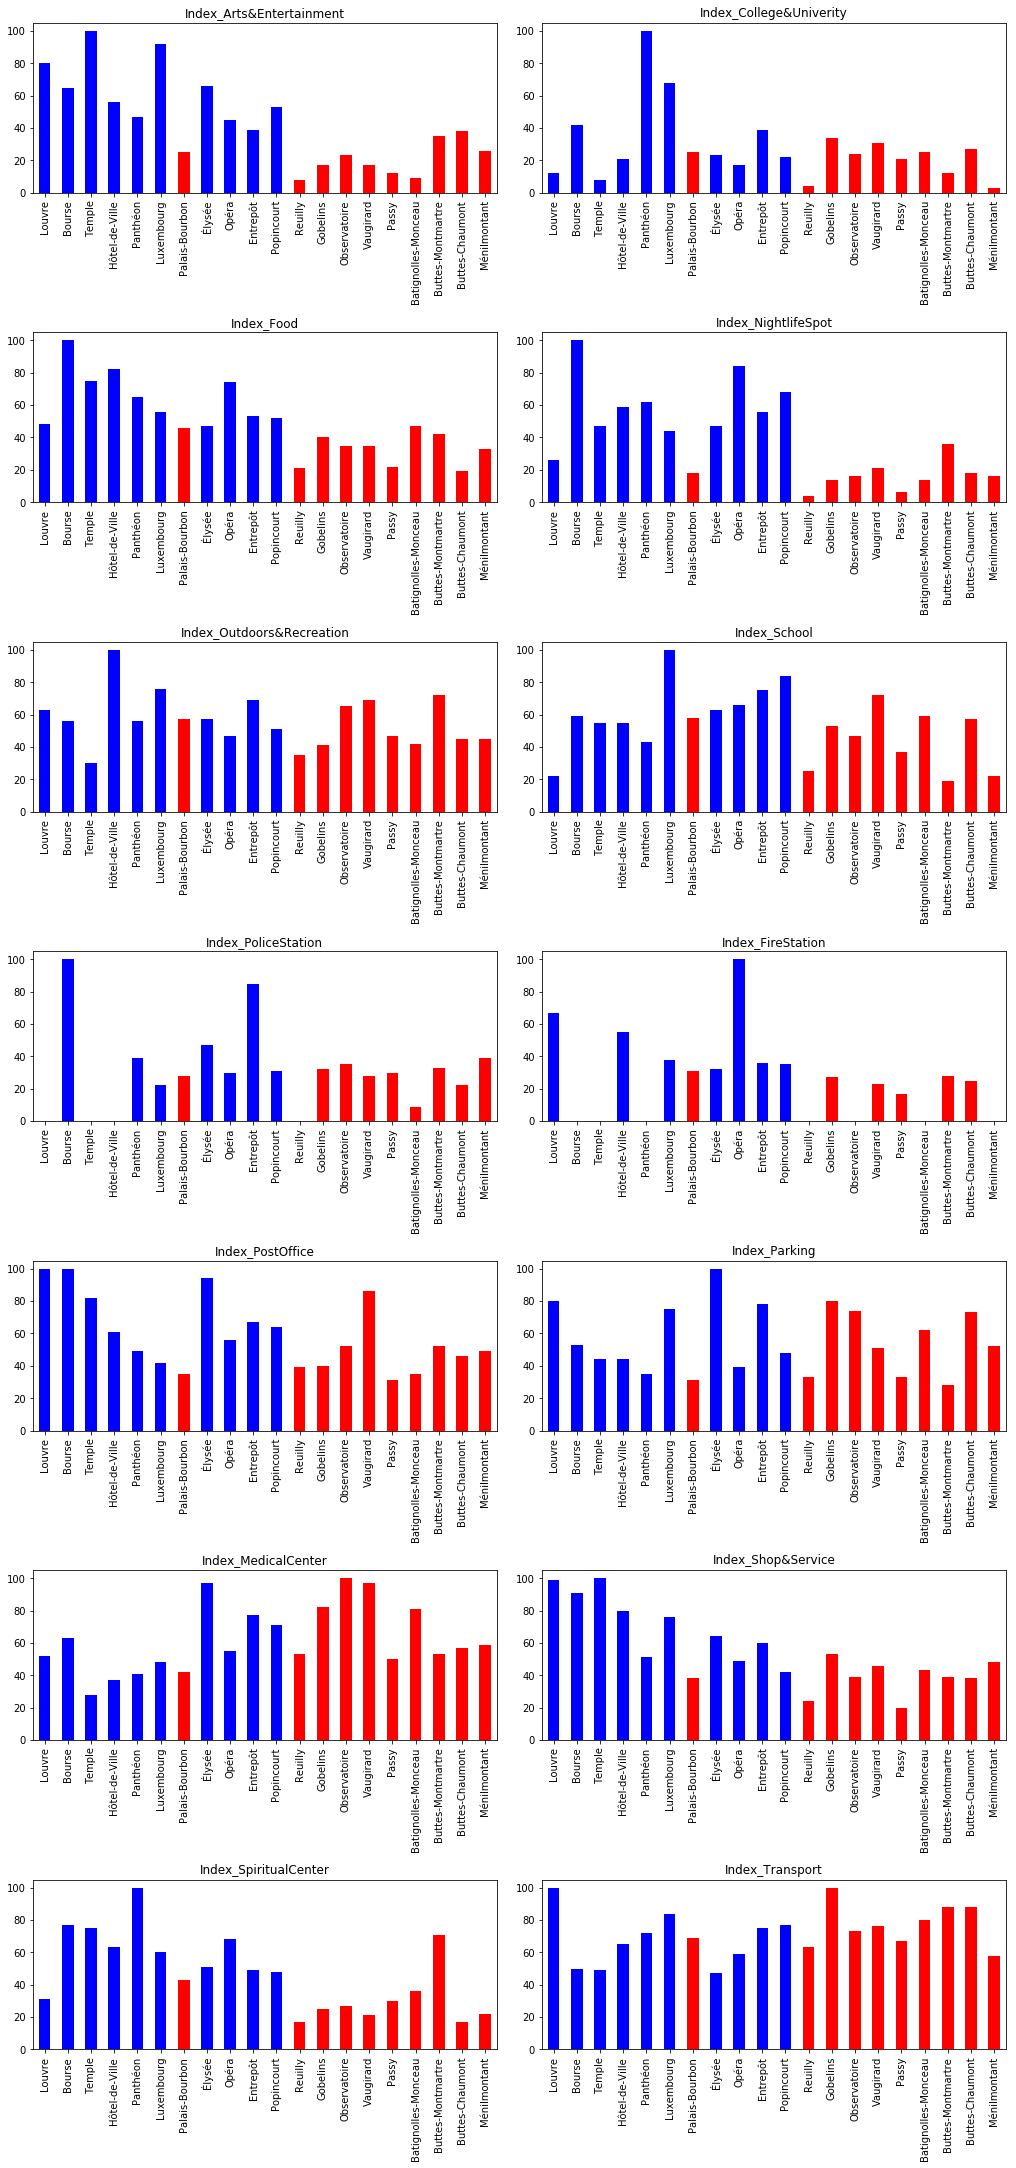

In [38]:
# Grid of plots for each category index
plot_cnt = 0
rows = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
cols = [0, 1]*7

fig, axs = plt.subplots(7, 2, constrained_layout=True)
colors = ['red', 'blue']
color_list = [colors[x] for x in df_paris['Cluster']]

for cat in norm_cats:
    df_paris[['Name', cat]].set_index('Name').plot(ax=axs[rows[plot_cnt], cols[plot_cnt]],
                                                   figsize=(14,30), color=[color_list],
                                                   kind='bar', legend=None, title=cat)
    axs[rows[plot_cnt], cols[plot_cnt]].set_xlabel('')
    plot_cnt += 1

A more "portable" version of the above plots.

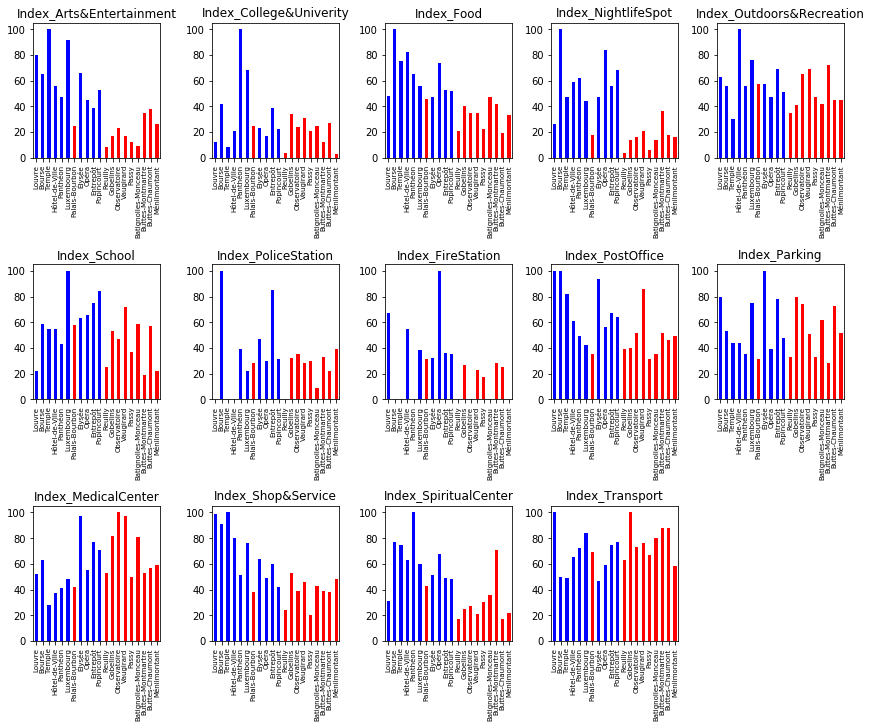

In [39]:
# Grid of plots for each category index
plot_cnt = 0
rows = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
cols = [0, 1, 2, 3, 4]*3

fig, axs = plt.subplots(3, 5, constrained_layout=True)
colors = ['red', 'blue']
color_list = [colors[x] for x in df_paris['Cluster']]

for cat in norm_cats:
    df_paris[['Name', cat]].set_index('Name').plot(ax=axs[rows[plot_cnt], cols[plot_cnt]],
                                                   figsize=(12,10), color=[color_list],
                                                   kind='bar', legend=None, title=cat)
    axs[rows[plot_cnt], cols[plot_cnt]].set_xlabel('')
    axs[rows[plot_cnt], cols[plot_cnt]].tick_params(axis='x', labelsize=7)
    plot_cnt += 1
    
# Cleaning unused subplot cells
fig.delaxes(axs[2][4])

It's not easy to understand what makes a neighborhood belong to a particular cluster, since we're considering 14 variables simultaneously.

We can for sure define the red cluster as having less arts & entertainement, less food establishments (restaurants), less nightlife spots, less shops & services and less spiritual centers. If we think about these features it helps to understand why this cluster maps (almost completely) to the outer neighborhoods, since thing like museums, restaurants, services, nightlife are tipically more concentrated on cities downtown.

Let's try to improve this visualization by using boxplots.

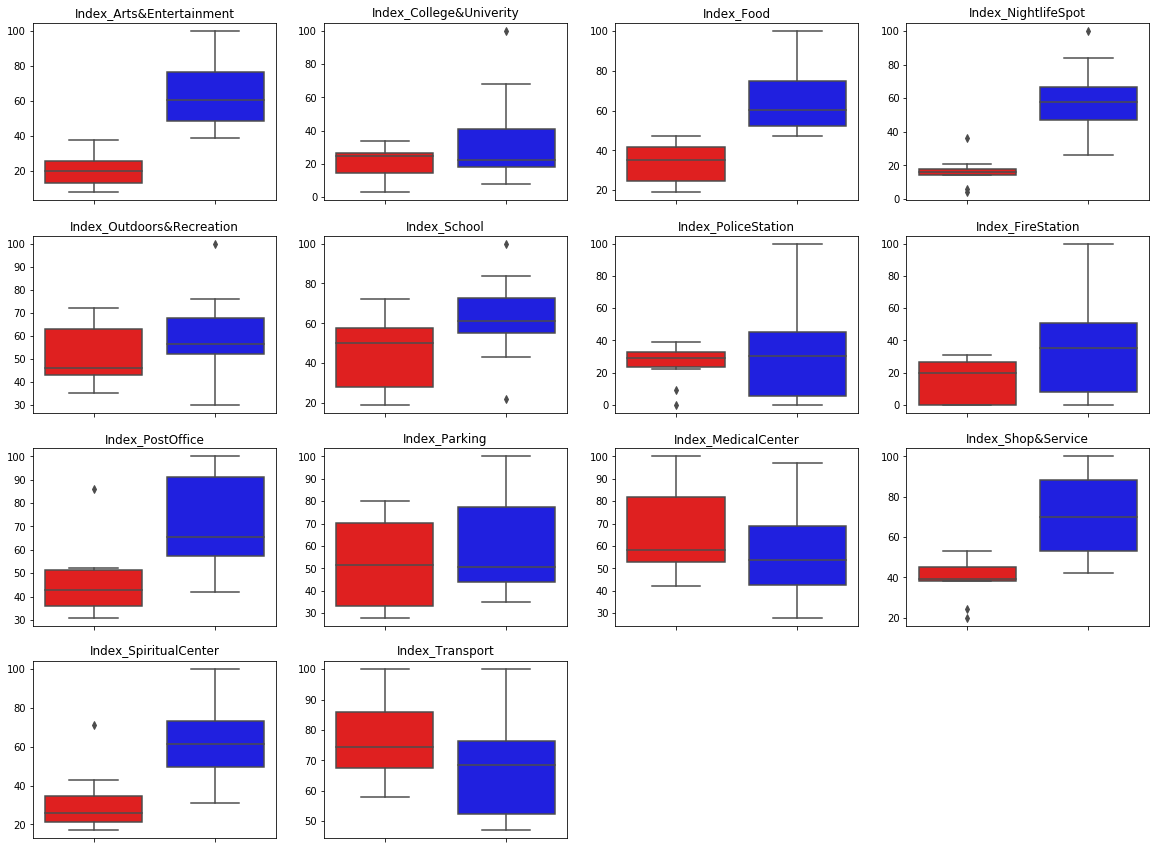

In [40]:
plot_cnt = 0
rows = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
cols = [0, 1, 2, 3]*4

fig, axs = plt.subplots(4, 4, figsize=(20, 15))

for y in norm_cats:
    sns.boxplot(x='Cluster', y=y, palette=['r', 'b'], data=df_paris, 
                ax=axs[rows[plot_cnt], cols[plot_cnt]])
    axs[rows[plot_cnt], cols[plot_cnt]].set_ylabel('')
    axs[rows[plot_cnt], cols[plot_cnt]].set_xlabel('')
    axs[rows[plot_cnt], cols[plot_cnt]].set_title(y)
    plt.setp(axs[rows[plot_cnt], cols[plot_cnt]].get_xticklabels(), visible=False)
    plot_cnt += 1
    
# Cleaning unused subplot cells
fig.delaxes(axs[3][2])
fig.delaxes(axs[3][3])

In [41]:
df_indexes = df_paris[norm_cats+['Cluster']].groupby('Cluster').mean().transpose()
df_indexes.columns = ['Red Cluster', 'Blue Cluster']
df_indexes['Diff'] = df_indexes['Red Cluster'] - df_indexes['Blue Cluster']
df_indexes['Diff'] = round(abs(df_indexes['Diff']), 2)

df_indexes.sort_values('Diff', ascending=False).style.apply(color_code, axis=1)

,Red Cluster,Blue Cluster,Diff
Index_Arts&Entertainment,21,64.3,43.3
Index_NightlifeSpot,16.3,59.3,43
Index_Shop&Service,38.8,71.2,32.4
Index_SpiritualCenter,30.9,62.2,31.3
Index_Food,34,65.2,31.2
Index_PostOffice,46.5,71.5,25
Index_FireStation,15.1,36.3,21.2
Index_School,44.9,62.2,17.3
Index_College&Univerity,20.6,35.2,14.6
Index_MedicalCenter,67.4,56.9,10.5


Looking at the boxplots and the table that compiles mean values for each index, is pretty straightforward to confirm that neighborhoods from the Blue cluster have superior mean values for almost every index.
As we can see the main differences were already indentified by looking at the bar charts for each index.

I think we basically understand the principle behind each cluster and how they almost map into a centrality criteria and helps us defining centrality as high density of services.


## 10) Comparing neighborhood value against price per m2

For a buyer, that intends to buy a property not as an investment but has a place to live, near to a plethora of services, comparing the features by looking to a huge ammount of charts can be a daunting task. Of course all these charts provide a more refined view of each neighborhood, but for a buyer that wants to narrow is options it would be good to have a single chart allowing to compare desnsity of services with property price.

Let's build an index per neighborhood that combines all the other indexes and then depict it against a color coded  map for the property price.

In [42]:
df_paris['Global_Index'] = df_paris[norm_cats].apply(sum, axis=1)
df_paris['Global_Index'] = round(100*df_paris['Global_Index']/df_paris['Global_Index'].max())
df_paris['Global_Index'] = df_paris['Global_Index'].apply(int)

df_paris

,Neighborhood,Name,Lat,Lon,PricePerM2,Radius,Arts & Entertainment,College & Univerity,Food,Nightlife Spot,Outdoors & Recreation,School,Police Station,Fire Station,Post Office,Parking,Medical Center,Shop & Service,Spiritual Center,Transport,Index_Arts&Entertainment,Index_College&Univerity,Index_Food,Index_NightlifeSpot,Index_Outdoors&Recreation,Index_School,Index_PoliceStation,Index_FireStation,Index_PostOffice,Index_Parking,Index_MedicalCenter,Index_Shop&Service,Index_SpiritualCenter,Index_Transport,Cluster,Global_Index
0,1,Louvre,48.862563,2.336443,12840,393.957360,21,5,48,16,19,3,0,1,4,6,9,73,2,10,80,12,48,26,63,22,0,67,100,80,52,99,31,100,1,82
1,2,Bourse,48.868279,2.342803,11250,393.957360,17,18,100,62,17,8,5,0,4,4,11,67,5,5,65,42,100,100,56,59,100,0,100,53,63,91,77,50,1,100
2,3,Temple,48.862872,2.360001,12260,482.317279,32,4,92,36,11,9,0,0,4,4,6,90,6,6,100,8,75,47,30,55,0,0,82,44,28,100,75,49,1,72
3,4,Hôtel-de-Ville,48.854341,2.357630,12790,482.317279,18,11,100,45,37,9,0,1,3,4,8,72,5,8,56,21,82,59,100,55,0,55,61,44,37,80,63,65,1,81
4,5,Panthéon,48.844443,2.350715,12140,605.874985,19,66,100,59,26,9,3,0,3,4,11,58,10,11,47,100,65,62,56,43,39,0,49,35,41,51,100,72,1,79
5,6,Luxembourg,48.849130,2.332898,14180,702.241870,43,52,100,49,41,24,2,1,3,10,15,100,7,15,92,68,56,44,76,100,22,38,42,75,48,76,60,84,1,92
6,7,Palais-Bourbon,48.856174,2.312188,13230,853.146598,14,23,100,24,37,17,3,1,3,5,16,60,6,15,25,25,46,18,57,58,28,31,35,31,42,38,43,69,0,57
7,8,Élysée,48.872721,2.312554,11240,839.324555,37,21,100,62,37,18,5,1,8,16,36,100,7,10,66,23,47,47,57,63,47,32,94,100,97,64,51,47,1,87
8,9,Opéra,48.877164,2.337458,10730,531.377372,16,10,100,70,19,12,2,2,3,4,13,49,6,8,45,17,74,84,47,66,30,100,56,39,55,49,68,59,1,83
9,10,Entrepôt,48.876130,2.360728,9730,737.803612,19,31,100,65,39,19,8,1,5,11,25,82,6,14,39,39,53,56,69,75,85,36,67,78,77,60,49,75,1,90


In [43]:
# Map with neighborhood index
paris_compare_map = folium.Map(location=[paris_lat, paris_lon], zoom_start=12)
c_map.add_to(paris_compare_map)

fg = folium.FeatureGroup(name='Neigborhood Compairison')
for idx, row in df_paris.iterrows():
    fg.add_child(folium.Marker(location=[row['Lat']+0.0025, row['Lon']-0.003],
                               icon=DivIcon(icon_size=(100,36),
                                            icon_anchor=(0,0),
                                            html='<div style="font-size: 10pt;color: #ffffff">%s</div>' % 
                                            row['Global_Index'],)))
    fg.add_child(folium.Circle(location=[row['Lat'], row['Lon']],
                               radius=row['Global_Index']*5,
                               popup=row['Name']+' ('+str(row['Neighborhood'])+') - '+str(row['PricePerM2'])+' €',
                               color='blue',
                               fill=True,
                               fill_color='blue',
                               fill_opacity=0.7))

paris_compare_map.add_child(fg)

paris_compare_map

In [44]:
cm_index = sns.light_palette("green", as_cmap=True)
cm_price = sns.light_palette("red", as_cmap=True)

df_index_price = df_paris[['Name','Global_Index','PricePerM2']]
df_index_price.set_index('Name', inplace=True)

df_index_price.style.background_gradient(cmap=cm_index)

,Global_Index,PricePerM2
Name,,
Louvre,82,12840
Bourse,100,11250
Temple,72,12260
Hôtel-de-Ville,81,12790
Panthéon,79,12140
Luxembourg,92,14180
Palais-Bourbon,57,13230
Élysée,87,11240
Opéra,83,10730


I will now rank the neighborhoods regading global index and price per m2.

In [73]:
df_ranks = pd.DataFrame({'Neighborhood': df_paris['Name']})

rank_GI = df_paris.sort_values('Global_Index', ascending=False)[['Name','Global_Index']]
rank_GI['Global Index Rank'] = list(np.arange(1,21))
rank_PPM2 = df_paris.sort_values('PricePerM2')[['Name','PricePerM2']]
rank_PPM2['Price Rank'] = list(np.arange(1,21))

df_ranks = df_ranks.join(rank_GI).drop('Name', axis=1).join(rank_PPM2).drop('Name', axis=1)
df_ranks.set_index('Neighborhood', inplace=True)

df_ranks

,Global_Index,Global Index Rank,PricePerM2,Price Rank
Neighborhood,,,,
Louvre,82,6,12840,18
Bourse,100,1,11250,14
Temple,72,10,12260,16
Hôtel-de-Ville,81,7,12790,17
Panthéon,79,8,12140,15
Luxembourg,92,2,14180,20
Palais-Bourbon,57,16,13230,19
Élysée,87,4,11240,13
Opéra,83,5,10730,12


In [77]:
df_paris[['Neighborhood', 'Name', 'PricePerM2']].set_index('Neighborhood')

,Name,PricePerM2
Neighborhood,,
1,Louvre,12840
2,Bourse,11250
3,Temple,12260
4,Hôtel-de-Ville,12790
5,Panthéon,12140
6,Luxembourg,14180
7,Palais-Bourbon,13230
8,Élysée,11240
9,Opéra,10730
